In [18]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
from OpenAIService import OpenAIService
# import sns
import seaborn as sns

In [2]:
service = OpenAIService()

In [3]:
LOCATION_PROCESSED = 'data_processed'
# read jsonl with pd
LOCATION = 'data'
SUBREDDIT = 'frugal'
FILENAME = f'r_{SUBREDDIT}_posts.jsonl'

original_df = pd.read_json(f"{LOCATION}/{FILENAME}", lines=True)

# print len of data
print("Total submissions: ", len(original_df))

Total submissions:  202008


Total submissions:  202008
Submissions with 0 comments:  43077
Sampling 200 from 158931 submissions
Total submissions (selected):  200


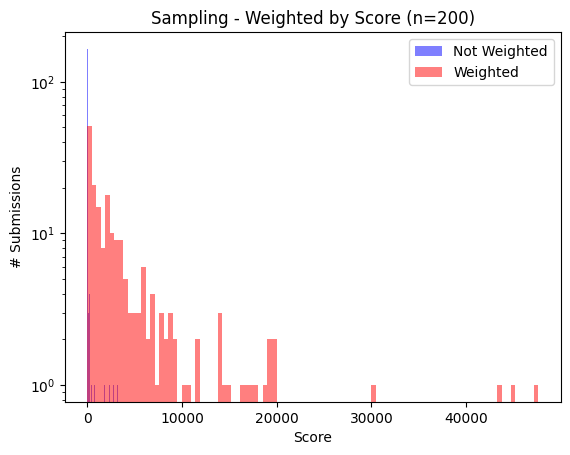

Index(['archived', 'author', 'author_flair_background_color',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_text_color', 'author_flair_type', 'brand_safe',
       'can_gild',
       ...
       'top_awarded_type', 'url_overridden_by_dest', 'gallery_data',
       'is_gallery', 'collections', 'call_to_action', 'poll_data',
       'author_is_blocked', '_meta', 'previous_selftext'],
      dtype='object', length=131)


,archived,author,author_flair_background_color,author_flair_css_class,author_flair_richtext,author_flair_text,author_flair_text_color,author_flair_type,brand_safe,can_gild,...,top_awarded_type,url_overridden_by_dest,gallery_data,is_gallery,collections,call_to_action,poll_data,author_is_blocked,_meta,previous_selftext
112159,0.0,PenisBeautyCream,None,None,[],None,None,text,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
181902,0.0,scooblyboop,None,None,[],None,None,text,NaN,0.0,...,None,NaN,NaN,NaN,NaN,NaN,NaN,0.0,"{'is_edited': True, 'retrieved_2nd_on': 168920...","So I, like many of you, thought we might get a..."
157208,0.0,visionsofdreams,None,None,[],None,None,text,NaN,1.0,...,None,https://i.redd.it/5hu3ec7qaib81.jpg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140827,1.0,IAmAPhysicsGuy,None,None,[],None,None,text,NaN,1.0,...,None,https://imgur.com/ZJeMLm6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70320,0.0,naura,NaN,None,NaN,None,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# df = pd.concat(df.values())

# remove duplicates
df = original_df.drop_duplicates(subset=['id'])
print("Total submissions: ", len(df))

# remove ones with num_comments == 0
before = len(df)
df = df[df['num_comments'] > 0]
print("Submissions with 0 comments: ", before - len(df))

# sample random 10 submissions
n = 200
print(f"Sampling {n} from {len(df)} submissions")
df2 = df.sample(n, random_state=42)
df = df.sample(n, weights='score', random_state=42)

# print("min:", df['num_comments'].min())

# dfs = dfs[:10]
print("Total submissions (selected): ", len(df))

# plot distribution of scores
plt.hist(df2['score'], bins=100, color='blue', alpha=0.5)
plt.hist(df['score'], bins=100, color='red', alpha=0.5)
plt.xlabel('Score')
plt.ylabel('# Submissions')
plt.yscale('log')
plt.title(f'Sampling - Weighted by Score (n={n})')
plt.legend(['Not Weighted', 'Weighted'])
plt.savefig(f'{LOCATION_PROCESSED}/weighted_sampling_distribution.png')
plt.show()

print(df.columns)
df.head()


In [5]:
# create new column for prediction
df['is_advice_seeking'] = np.nan

for index, row in df.iterrows():
    submission_text = f"{row['title']}"

    flair = row['link_flair_text']
    if not pd.isna(flair):
        submission_text += f"\n{flair}"

    selftext = row['selftext']
    if not pd.isna(selftext):
        submission_text += f"\n{selftext}"
    
    print(submission_text)
    print("-----------------------------------")
    label = service.is_submission_advice_seeking(submission_text)
    print("OPENAI: Does the user seek advice?: ", label)

    df.at[index, 'is_advice_seeking'] = label
    
    print("------------------------------------------------------------------------")


I've been eating slow cooker vegetarian red beans and brown rice for lunch 5 days a week. It costs less than $6 a month and I've even lost a little weight.
I love red beans and rice enough to eat it every weekday. I get dried beans and brown rice for $0.99/lb. and use a can of diced tomatoes and some seasoning, so it costs less than $6 for 4 weeks' worth of weekday lunches. Rather than spend money on sausage, I use liquid smoke and soy sauce for a meaty flavor. I make a big batch and put some of it in the freezer to be thawed as needed. Every weekday, I just heat up a serving in the microwave for 90 seconds and have a healthy, filling lunch. It has lots of fiber and antioxidants, and beans and rice together form a complete protein. I don't have a scale, but I've noticed my pants feeling a little looser in the waist.

&#x200B;

Here's how I make 10 days' worth: Soak 1 lb. small dried red beans in 6 cups water overnight in a covered bowl on the counter. In a separate bowl, soak 1 lb. bro

KeyboardInterrupt: 

In [6]:
# count how many submissions are seeking advice
print(df['is_advice_seeking'].value_counts())

# print percentage of submissions seeking advice
print(df['is_advice_seeking'].value_counts(normalize=True))

Series([], Name: count, dtype: int64)
Series([], Name: proportion, dtype: float64)


In [7]:
# save the results
df.to_json(f"{LOCATION_PROCESSED}/{FILENAME}", lines=True, orient='records')

In [8]:
print("Total tokens used:", service.total_tokens_used)

Total tokens used: 0


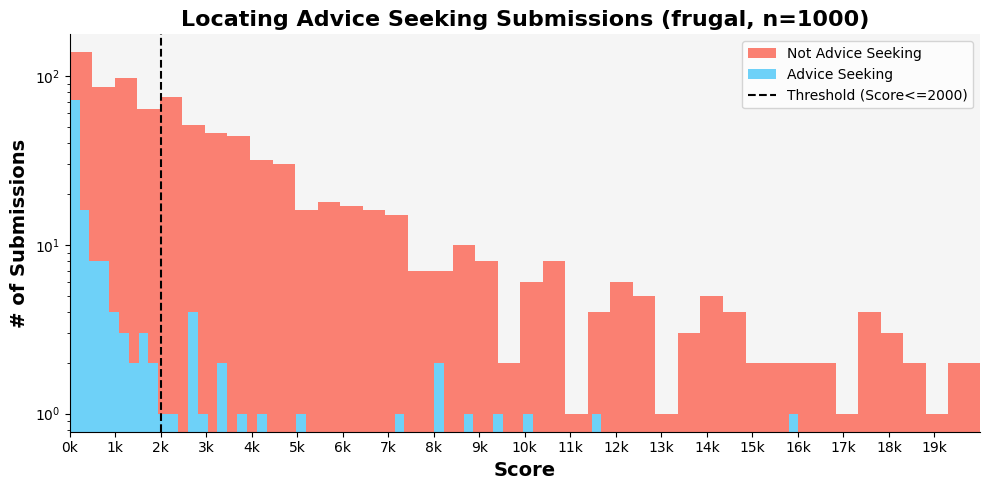

In [51]:
# filter out submissions that are not seeking advice
df_load = pd.read_json(f"{LOCATION_PROCESSED}/{FILENAME}", lines=True)

df_not_advice_seeking = df_load[df_load['is_advice_seeking'] == False]
df_advice_seeking = df_load[df_load['is_advice_seeking'] == True]

# mean of num_comments
# na_mean = int(df_not_advice_seeking['num_comments'].mean())
# na_std = int(df_not_advice_seeking['num_comments'].std())
# a_mean = int(df_advice_seeking['num_comments'].mean())
# a_std = int(df_advice_seeking['num_comments'].std())

# print("Mean and std of num_comments (Not Advice Seeking): ", na_mean, na_std)
# print("Mean and std of num_comments (Advice Seeking): ", a_mean, a_std)
LIMIT = 20000
BIN_SIZE = 200
COLORS = ['#6ED1F8', 'salmon', "#F5F5F5"]

df_not_advice_seeking['score'].plot.hist(bins=LIMIT//BIN_SIZE, label=f'Not Advice Seeking', color=COLORS[1], alpha=1)
df_advice_seeking['score'].plot.hist(bins=LIMIT//BIN_SIZE, label=f'Advice Seeking', color=COLORS[0], alpha=1)

plt.yscale('log')

#set face color to white
plt.gca().set_facecolor(COLORS[2])

plt.title(f'Locating Advice Seeking Submissions ({SUBREDDIT}, n={len(df_load)})', fontsize=16, weight='bold')

# create margin between the title and plot
plt.subplots_adjust(top=0.85)

plt.xlabel('Score', fontsize=14, weight='bold')
plt.ylabel('# of Submissions', fontsize=14, weight='bold')


# make plot wider
plt.gcf().set_size_inches(10, 5)

THRESHOLD = 2000

# plot a vertical line at threshold
plt.axvline(x=THRESHOLD, color='black', linestyle='--', label=f'Threshold (Score<={THRESHOLD})')
plt.legend()

# format x axis to be in thousands like 1.5k
plt.xticks(np.arange(0, LIMIT, 1000), [f"{x//1000}k" for x in np.arange(0, 20000, 1000)])

#remove axis on top and right
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)


plt.xlim(0, LIMIT)
plt.tight_layout()
plt.savefig(f"{LOCATION_PROCESSED}/locating_advice_seeking_submissions.png", dpi=500)
# plt.savefig(f"{LOCATION_PROCESSED}/score_distribution_advice_zoom.png")
plt.show()

In [ ]:
# min score
print("Min score advice seeking: ", df['score'].min())

# max score
print("Max score advice seeking: ", df['score'].max())


Min score advice seeking:  2
Max score advice seeking:  49485


In [ ]:
df_load_test = pd.read_csv(f"{LOCATION_PROCESSED}/{FILENAME}")

# filter on scores < 2000
df_load_test = df_load_test[df_load_test['score'] < 2000]

# print percentage of submissions seeking advice
print(df_load_test['is_advice_seeking'].value_counts(normalize=True))

In [ ]:
service.total_tokens_used